# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Критерий успешности проекта :
**MAE < 6.8**

## План и исследование данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error

#models
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
def get_info(data: pd.DataFrame):
    display(data.head())
    print('\n INFO\n')
    data.info()
    print('\n Дупликаты общие \n')
    display(data[data.duplicated()])
    print('\n Пропущенные данные в % \n')
    display(data.isna().mean()*100)
    display(data.describe(include='all'))

### data_arc_new.csv

In [1]:
# Загрузка данных
data_arc = pd.read_csv('data_arc_new.csv')

NameError: name 'pd' is not defined

In [4]:
get_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

 Дупликаты общие 



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность



 Пропущенные данные в % 



key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-08-28 22:13:27,2019-05-04 05:12:08,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201


Есть отрицательная реактивная мощность, рассмотрим гистограммы Активной мощности и Реактивной

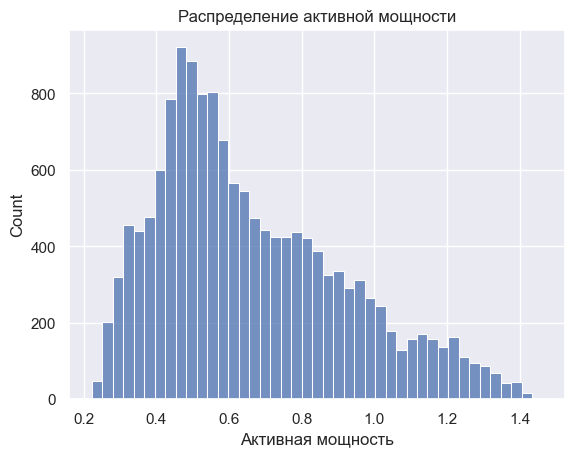

In [5]:
sns.set(style="darkgrid")
sns.histplot(data=data_arc, x="Активная мощность").set_title('Распределение активной мощности')
plt.show()

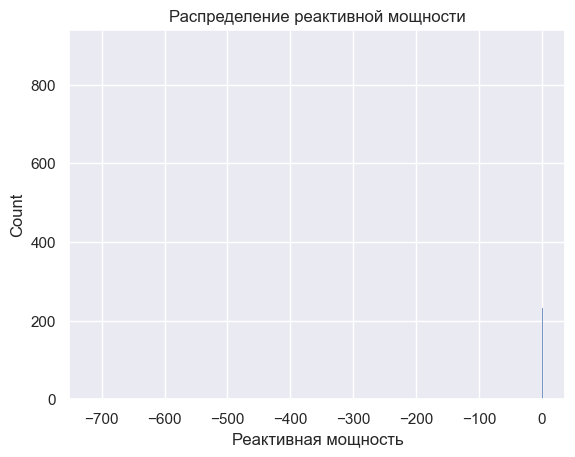

In [6]:
sns.set(style="darkgrid")
sns.histplot(data=data_arc, x="Реактивная мощность").set_title('Распределение реактивной мощности')
plt.show()

Рапсределение реактивной мощности не очень, рассмотрим элементы, значение которых ниже нуля

In [7]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Рассмотрим корреляцию на элементах, где нет этого аномального значения

In [8]:
data_arc[~(data_arc['Реактивная мощность'] < 0)]['Реактивная мощность']\
            .corr(data_arc[~(data_arc['Реактивная мощность'] < 0)]['Активная мощность'])

0.9663734456187303

Думаю, аномальное значение можно восстановить по корреляции

Также хочу добавить, что можно добавить признак - потребление, произведение активной мощности на время.

### data_bulk_new.csv

In [9]:
# Загрузка данных
data_bulk = pd.read_csv('data_bulk_new.csv')

In [10]:
get_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

 Дупликаты общие 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15



 Пропущенные данные в % 



key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Здесь пустые значения просто надо заполнить нулями, так как пустое значение говорит о том, что сыпучий материал не подавался

Можно рассмотреть гистограммы, где std больше 100, и при этом большое количество записей, например bulk 12

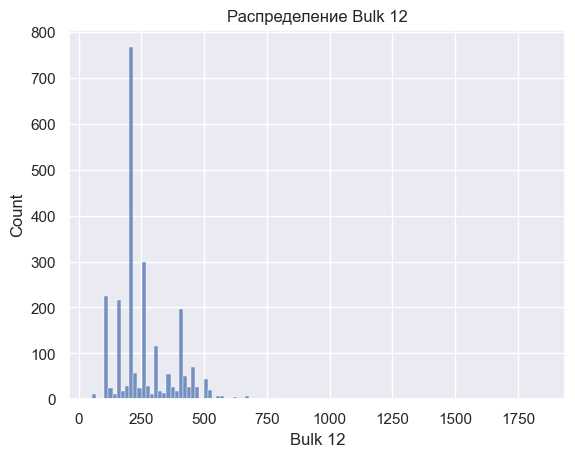

In [11]:
sns.set(style="darkgrid")
sns.histplot(data=data_bulk, x="Bulk 12").set_title('Распределение Bulk 12')
plt.show()

довольно большой пик, но думаю это часть бизнес-процесса

### data_bulk_time_new.csv

In [12]:
# Загрузка данных
data_bulk_time = pd.read_csv('data_bulk_time_new.csv')

In [13]:
get_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

 Дупликаты общие 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15



 Пропущенные данные в % 



key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-06-19 21:59:12,2019-05-07 19:13:07,2019-06-14 23:02:32,2019-05-26 14:54:06,2019-05-07 15:19:17,2019-08-31 01:24:06,2019-07-27 08:58:52,2019-07-08 17:14:53,2019-05-14 13:02:53,2019-08-01 20:35:37,2019-06-17 09:00:16,2019-07-06 21:31:26,2019-05-05 02:10:21,2019-05-17 04:05:58,2019-08-09 04:31:52
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как и в предыдущей таблице, здесь пустые значения просто надо заполнить нулями, так как пустое значение говорит о том, что сыпучий материал не подавался

### data_gas_new.csv

In [14]:
# Загрузка данных
data_gas = pd.read_csv('data_gas_new.csv')

In [15]:
get_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

 Дупликаты общие 



,key,Газ 1



 Пропущенные данные в % 



key      0.0
Газ 1    0.0
dtype: float64

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


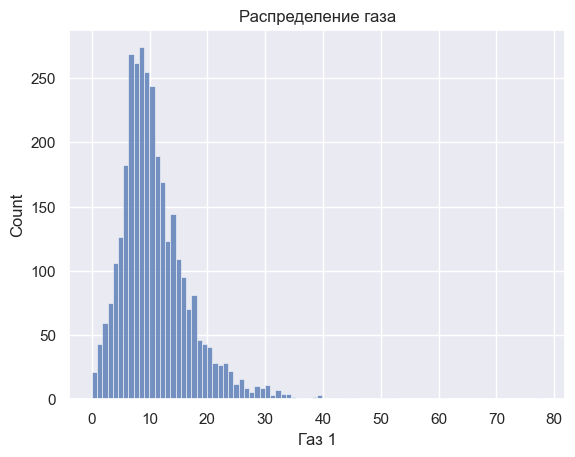

In [16]:
sns.set(style="darkgrid")
sns.histplot(data=data_gas, x="Газ 1").set_title('Распределение газа')
plt.show()

ну здесь всё в порядке, распределение со скосом справа

### data_temp_new.csv

In [17]:
#Загрузка данных
data_temp = pd.read_csv('data_temp_new.csv')

In [18]:
get_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

 Дупликаты общие 



,key,Время замера,Температура



 Пропущенные данные в % 



key              0.000000
Время замера     0.000000
Температура     18.942074
dtype: float64

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
unique,NaN,18092,NaN
top,NaN,2019-06-03 01:48:34,NaN
freq,NaN,1,NaN
mean,1616.460977,NaN,1590.722741
std,934.641385,NaN,20.394381
min,1.000000,NaN,1191.000000
25%,807.750000,NaN,1580.000000
50%,1618.000000,NaN,1590.000000
75%,2429.000000,NaN,1599.000000


пропуск - проблема с датчиком, удаляем всю партию целиком

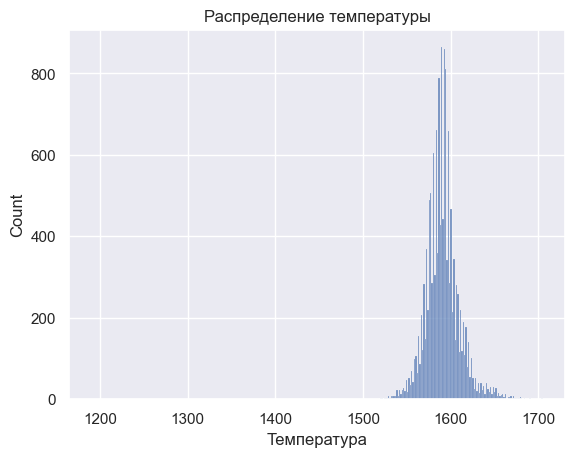

In [19]:
sns.set(style="darkgrid")
sns.histplot(data=data_temp, x="Температура").set_title('Распределение температуры')
plt.show()

То, что меньше 1500 можно убрать, это явно тоже проблема с датчиками, также всю партирю убираем.

Рассмотрим, сколько партий всего убирем

In [20]:
len(data_temp[(data_temp['Температура'].isna()) | (data_temp['Температура'] < 1500)].key.unique())

743

Придется отказаться от стольки партий в обучающей выборке

В признаки берем только первую температуру, последняя температура - целевой признак

### data_wire_new.csv

In [21]:
# Загрузка данных
data_wire = pd.read_csv('data_wire_new.csv')

In [22]:
get_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

 Дупликаты общие 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9



 Пропущенные данные в % 



key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Здесь пустые значения просто надо заполнить нулями, так как пустое значение говорит о том, что проволочный материал не подавался

### data_wire_time_new.csv

In [23]:
# Загрузка данных
data_wire_time = pd.read_csv('data_wire_time_new.csv')

In [24]:
get_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

 Дупликаты общие 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9



 Пропущенные данные в % 



key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-08-27 16:29:04,2019-07-04 22:01:14,2019-07-19 05:51:49,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 01:13:45,2019-08-16 04:37:28,2019-08-09 06:49:04
freq,NaN,1,1,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как и в предыдущей таблице, здесь пустые значения просто надо заполнить нулями, так как пустое значение говорит о том, что проволочный материал не подавался

### Итог

Как обрабатывать пропуски, аномальные значения написаны в подпунктах выше

Признаки:
- `data_arc_new.csv` — Потребление(произведение времени на активную мощность), Реактивная мощность - либо ее суммирование, либо также как и потребление(произведение реактивной мощности на время;
- `data_bulk_new.csv` — Используем все столбцы как признаки(пропуски - нули);
- `data_bulk_time_new.csv` — Думаю, можно не использовать;
- `data_gas_new.csv` — Там единственный столбец признак;
- `data_temp_new.csv` — Первая температура - признак, последняя - целевой признак;
- `data_wire_new.csv` — Используем все столбцы как признаки(пропуски - нули);
- `data_wire_time_new.csv` — Думаю, можно не использовать.

Итоговая таблица - inner join всех таблиц по ключу key

<a id='Plan'></a>
### План

1. Предобработка данных. Здесь просто заполнить пропуски
2. Соединить таблицы по ключу key через inner join. Так мы получим одну общую таблицу
3. Инициализировать признаки и таргет.
4. Разделить на тестовую и обучающую выборку. Также не забыть удалить выбросы в тренировочной выборке.
5. Построить модели и обучить их. Использовать модели(пока это catboost, linear regression и random forest) с GridSearchCV (или RandomizedSearchCV), перебирая 2-3 параметраю
6. Протестировать модель. Взять модель с лучшим score и протестировать ее на тестовой.
7. Написать отчёт

## Предобработка

### data_arc_new

In [25]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Восстановим реаткивную мощность с помощью регрессии, так как между данными есть корреляция

In [26]:
data_arc.loc[9780, 'Реактивная мощность']

-715.479924

In [27]:
model = LinearRegression()
model.fit(data_arc[~(data_arc['Реактивная мощность'] < 0)]['Активная мощность'].values.reshape(-1, 1), 
          data_arc[~(data_arc['Реактивная мощность'] < 0)]['Реактивная мощность'].values.reshape(-1, 1))
predicted = model.predict(data_arc.loc[9780, 'Активная мощность'].reshape(1, -1))
predicted

array([[0.51853445]])

In [28]:
data_arc.loc[9780, 'Реактивная мощность'] = predicted[0][0]

Создадим признак "Работа"("work"), что есть произведение времени на мощность. Возьмем активную мощность, так как другая мощность имеет корреляцию. По реактивной мощности возьмем среднее

In [29]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [30]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [31]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [32]:
data_arc['work'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).\
                            dt.total_seconds() * data_arc['Активная мощность']

In [33]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,128.335684


In [34]:
data_arc = data_arc.pivot_table(index='key', values=['work', 'Реактивная мощность'], 
                                aggfunc={"work": 'sum', "Реактивная мощность": 'mean'})

In [35]:
data_arc.head(5)

,work,Реактивная мощность
key,,
1,628.616930,0.428564
2,395.281800,0.363339
3,581.774624,0.587491
4,543.710274,0.514248
5,412.180480,0.421998


In [36]:
data_arc.tail(5)

,work,Реактивная мощность
key,,
3237,493.152191,0.405083
3238,229.390861,0.346034
3239,751.674870,0.442693
3240,530.736187,0.474710
3241,438.456455,0.428002


### data_bulk_new

In [37]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Здесь просто заполним нулями

In [38]:
data_bulk.fillna(0, inplace=True)

In [39]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### data_gas_new

In [40]:
data_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Здесь всё норм

### data_temp_new

In [41]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [42]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [43]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Удалим партии с супер выбросом(температура меньше 1500) и NaN значениями

In [44]:
keys = list(data_temp[(data_temp['Температура'].isna()) | (data_temp['Температура'] < 1500)].key.unique())
keys

[867,
 1214,
 1619,
 2052,
 2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,


In [45]:
data_temp = data_temp[~(data_temp['key'].isin(keys))]

In [46]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13905 non-null  int64         
 1   Время замера  13905 non-null  datetime64[ns]
 2   Температура   13905 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


Найдем партии, где есть один замер и уберем их

In [47]:
keys_one_measure = list(data_temp.groupby('key').filter(lambda x: len(x) == 1).key.values)
keys_one_measure

[195, 279]

In [48]:
data_temp = data_temp[~(data_temp['key'].isin(keys_one_measure))]

In [49]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


Отсортируем значения по времени замера

In [50]:
data_temp = data_temp.sort_values(by='Время замера')

Возьмем первые и последние темепратуры

In [51]:
data_temp = data_temp.pivot_table(index='key', values=['Температура', 'Время замера'], aggfunc=['first', 'last'])\
            .droplevel(1, axis=1)

In [52]:
data_temp.info()
data_temp.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   first   2471 non-null   datetime64[ns]
 1   first   2471 non-null   float64       
 2   last    2471 non-null   datetime64[ns]
 3   last    2471 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.5 KB


,first,first,last,last
key,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


In [53]:
data_temp.columns = ['first_time', 'first_temperature', 'last_time', 'last_temperature']

In [54]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_time         2471 non-null   datetime64[ns]
 1   first_temperature  2471 non-null   float64       
 2   last_time          2471 non-null   datetime64[ns]
 3   last_temperature   2471 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.5 KB


In [55]:
data_temp['time'] = (data_temp['last_time'] - data_temp['first_time']).dt.total_seconds()
data_temp.head(5)

,first_time,first_temperature,last_time,last_temperature,time
key,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0


In [56]:
data_temp.drop(['first_time', 'last_time'], axis=1, inplace=True)
data_temp.info()
data_temp.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temperature  2471 non-null   float64
 1   last_temperature   2471 non-null   float64
 2   time               2471 non-null   float64
dtypes: float64(3)
memory usage: 77.2 KB


,first_temperature,last_temperature,time
key,,,
1,1571.0,1613.0,1714.0
2,1581.0,1602.0,1265.0
3,1596.0,1599.0,1753.0
4,1601.0,1625.0,1220.0
5,1576.0,1602.0,1536.0


### data_wire_new

In [57]:
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заполняем нулями

In [58]:
data_wire.fillna(0, inplace=True)

In [59]:
data_wire.info()
data_wire.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Признаки готовы, можно объединять таблицы

### merge

In [60]:
data = (data_arc.merge(data_bulk, how='inner', left_index=True, right_on='key')\
        .merge(data_gas, how='inner', on = 'key')\
        .merge(data_temp, how='inner', left_on='key', right_index=True)\
        .merge(data_wire, how='inner', on = 'key'))
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   work                 2325 non-null   float64
 1   Реактивная мощность  2325 non-null   float64
 2   key                  2325 non-null   int64  
 3   Bulk 1               2325 non-null   float64
 4   Bulk 2               2325 non-null   float64
 5   Bulk 3               2325 non-null   float64
 6   Bulk 4               2325 non-null   float64
 7   Bulk 5               2325 non-null   float64
 8   Bulk 6               2325 non-null   float64
 9   Bulk 7               2325 non-null   float64
 10  Bulk 8               2325 non-null   float64
 11  Bulk 9               2325 non-null   float64
 12  Bulk 10              2325 non-null   float64
 13  Bulk 11              2325 non-null   float64
 14  Bulk 12              2325 non-null   float64
 15  Bulk 13              2325 non-null   f

,work,Реактивная мощность,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,628.616930,0.428564,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,1714.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,395.281800,0.363339,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,1265.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,581.774624,0.587491,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,1753.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,543.710274,0.514248,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,1220.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,412.180480,0.421998,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,1536.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Исследование признаков

In [61]:
def build_graphics(colomn_name: str, data):
    if 'Bulk' in colomn_name or "Wire" in colomn_name:
        data = data[~(data[colomn_name] == 0)]
    sns.histplot(data=data, x=colomn_name).set_title('Распределение в столбце ' + colomn_name)
    plt.show()
    sns.boxplot(x=data[colomn_name]).set_title('Boxplot столбца ' + colomn_name)
    plt.show()
    Q1 = data[colomn_name].quantile(0.25)
    Q3 = data[colomn_name].quantile(0.75)
    IQR = Q3 - Q1
    min_ = Q1-1.5*IQR
    max_ = Q3+1.5*IQR
    print('min: ', min_)
    print('max: ', max_)
    print('Количество выбросов: ', len(data[(data[colomn_name] < min_) | (data[colomn_name] > max_)]))

### work

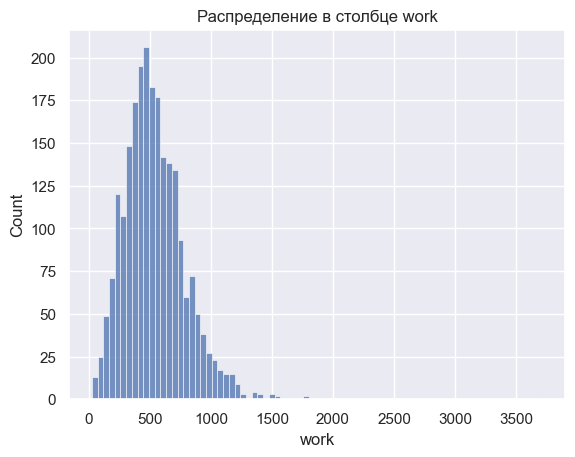

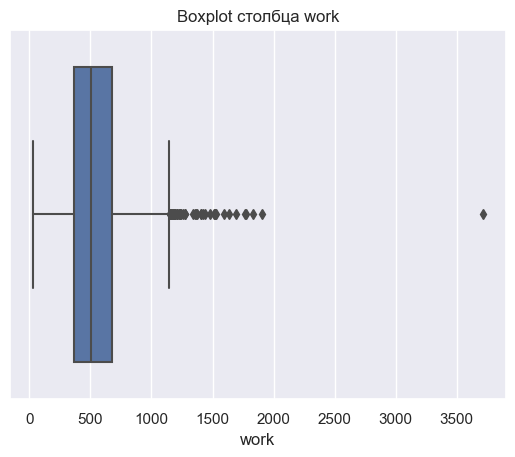

min:  -98.07789450000001
max:  1145.3463415
Количество выбросов:  48


In [62]:
build_graphics('work', data)

Распределение со скосом справа, выбросы есть. Уберем то, что больше 3000

### Реактивная мощность(mean)

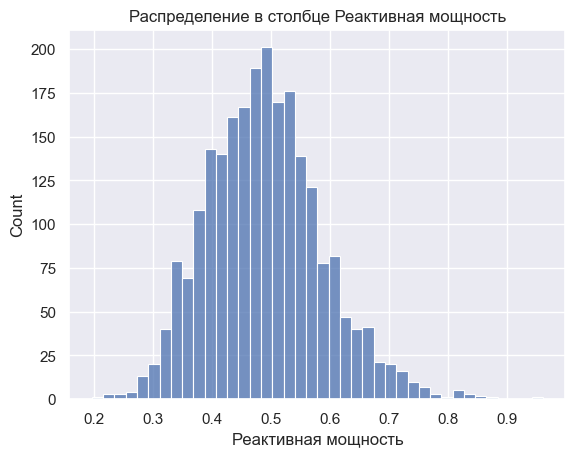

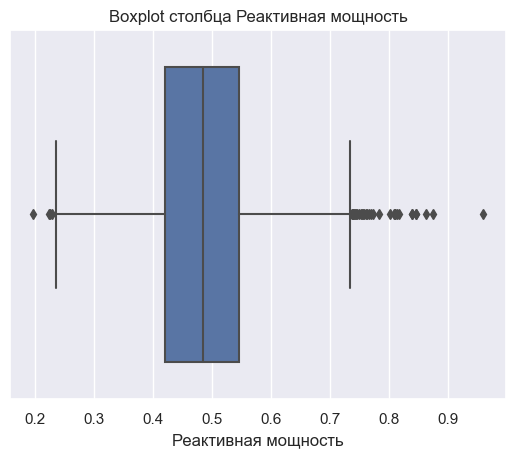

min:  0.2300970833333333
max:  0.7366404166666667
Количество выбросов:  36


In [63]:
build_graphics('Реактивная мощность', data)

Данных итак мало, думаю можно удалить только крайние выбросы(>0.9)

### Bulk 1

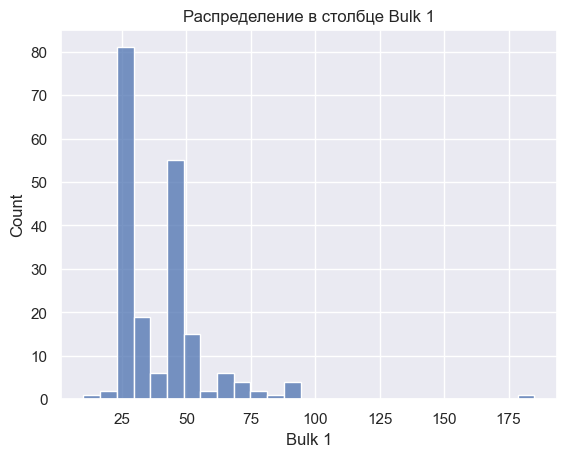

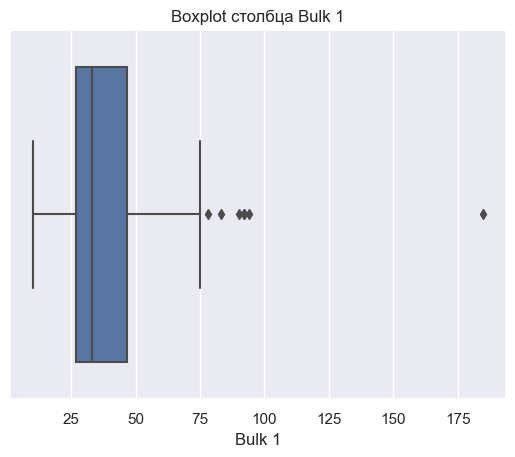

min:  -2.25
max:  75.75
Количество выбросов:  7


In [64]:
build_graphics('Bulk 1', data)

Выбросы - часть бизнес-процесса, думаю, не стоит трогать, данных итак мало. Можно убрать самый крайний, который больше 175

### Bulk 2

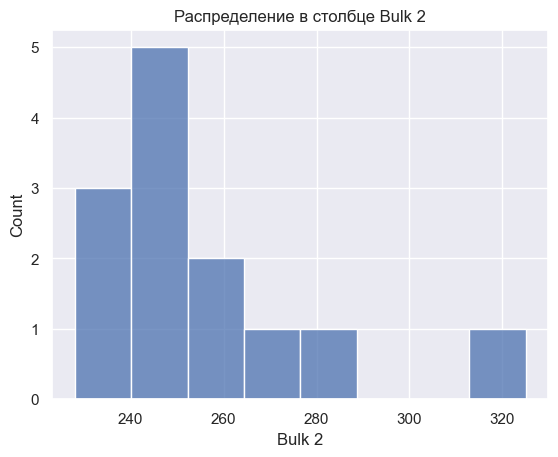

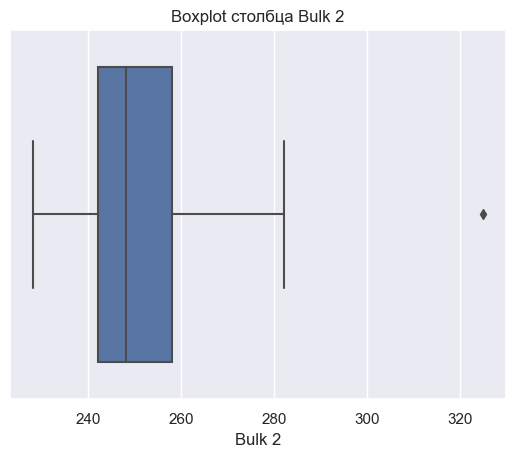

min:  218.0
max:  282.0
Количество выбросов:  1


In [65]:
build_graphics('Bulk 2', data)

ничего не стоит убирать

### Bulk 3

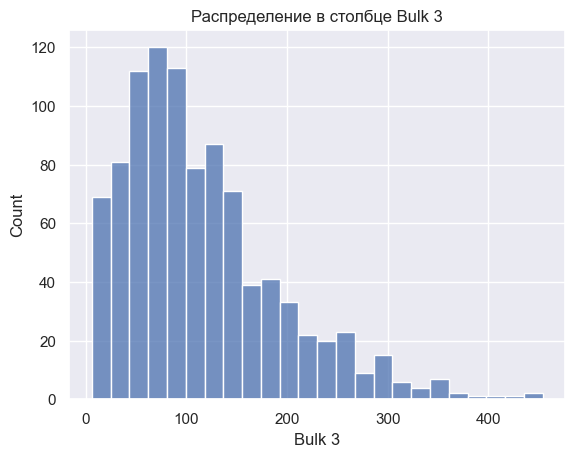

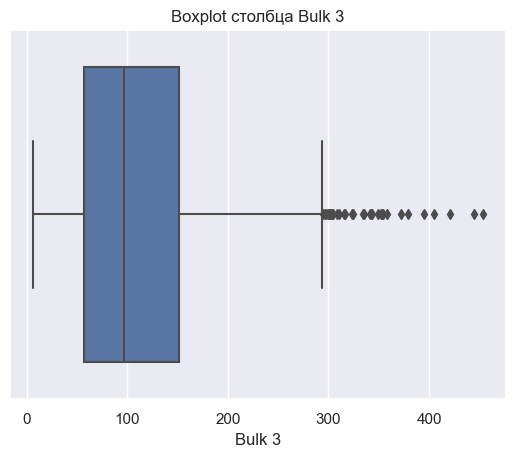

min:  -84.875
max:  294.125
Количество выбросов:  33


In [66]:
build_graphics('Bulk 3', data)

Тоже ничего не стоит трогать

### Bulk 4

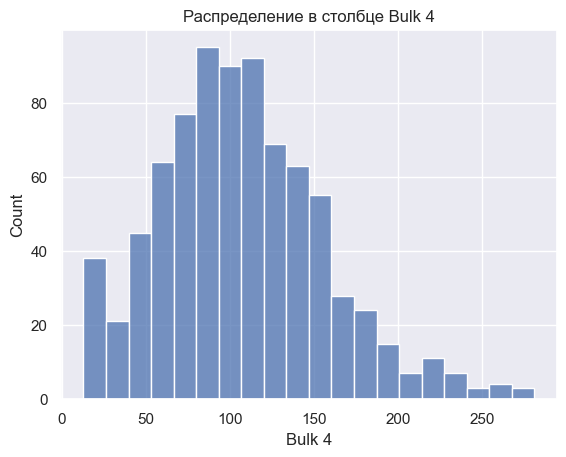

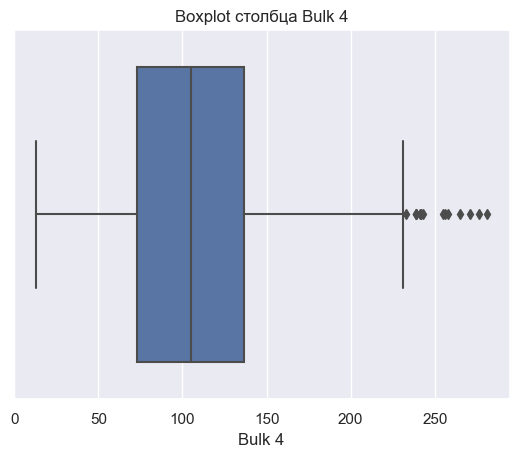

min:  -22.25
max:  231.75
Количество выбросов:  14


In [67]:
build_graphics('Bulk 4', data)

Тоже ничего не стоит трогать

### Bulk 5

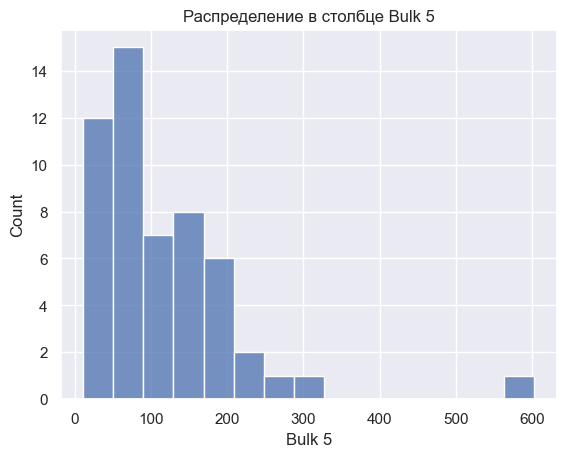

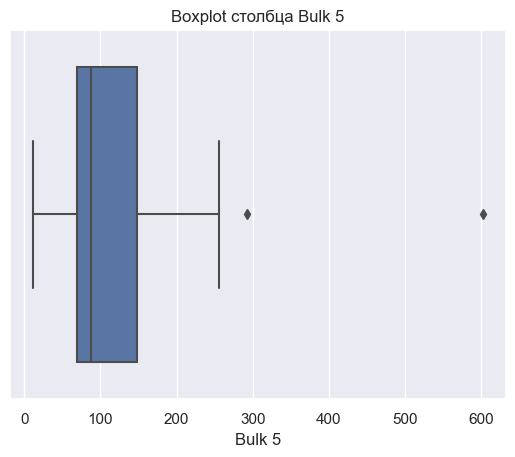

min:  -47.0
max:  265.0
Количество выбросов:  2


In [68]:
build_graphics('Bulk 5', data)

убрать то, что больше 600

### Bulk 6

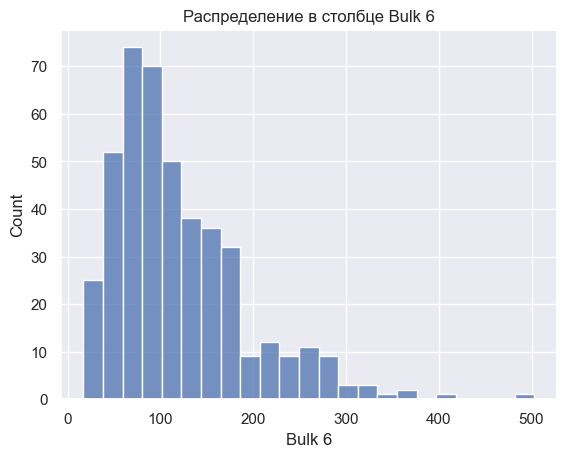

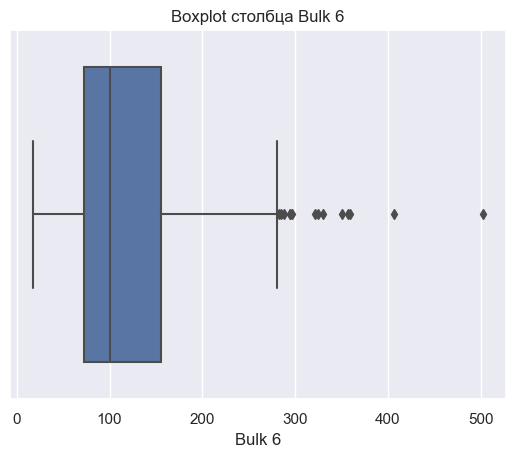

min:  -53.625
max:  281.375
Количество выбросов:  14


In [69]:
build_graphics('Bulk 6', data)

Убрать то, что больше 500

### Bulk 7

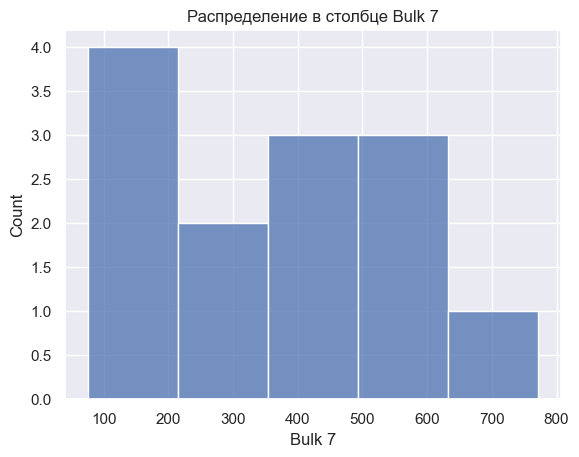

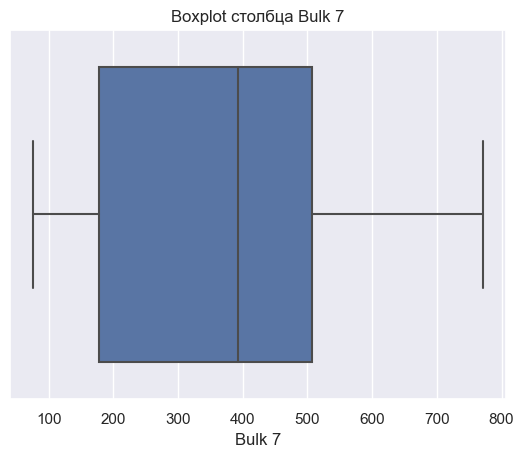

min:  -315.5
max:  1000.5
Количество выбросов:  0


In [70]:
build_graphics('Bulk 7', data)

### Bulk 8

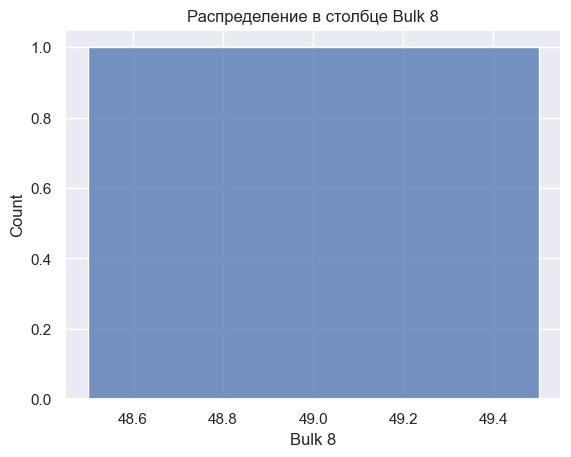

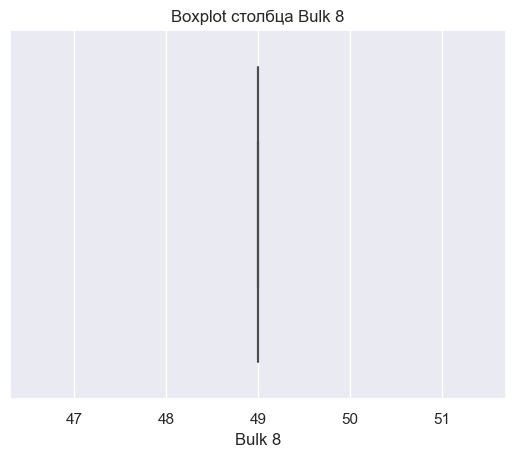

min:  49.0
max:  49.0
Количество выбросов:  0


In [71]:
build_graphics('Bulk 8', data)

### Bulk 9

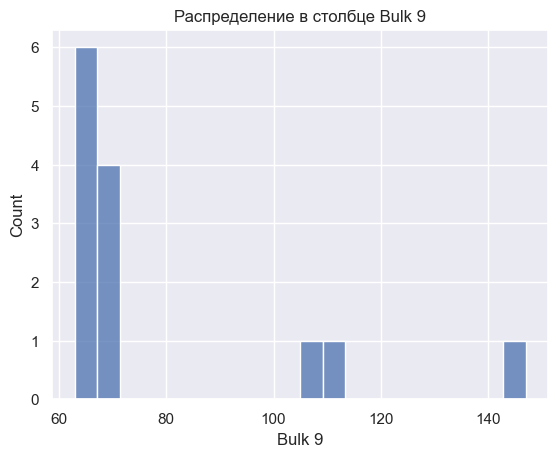

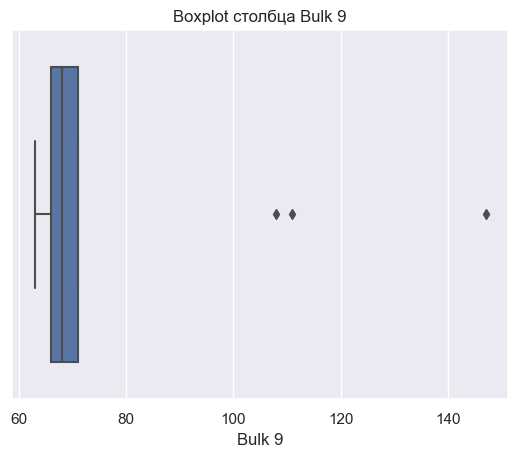

min:  58.5
max:  78.5
Количество выбросов:  3


In [72]:
build_graphics('Bulk 9', data)

малое количество данных, следует оставить 

### Bulk 10

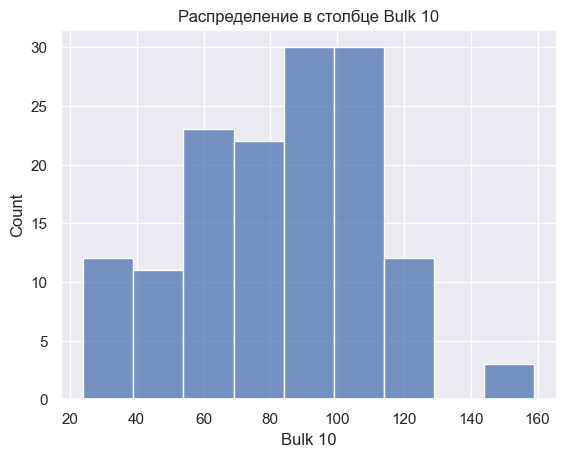

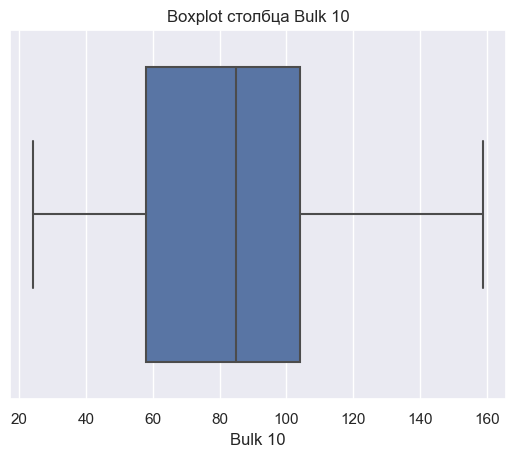

min:  -11.0
max:  173.0
Количество выбросов:  0


In [73]:
build_graphics('Bulk 10', data)

### Bulk 11

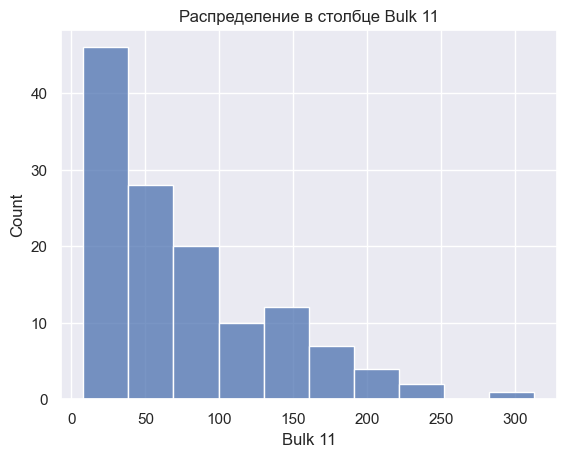

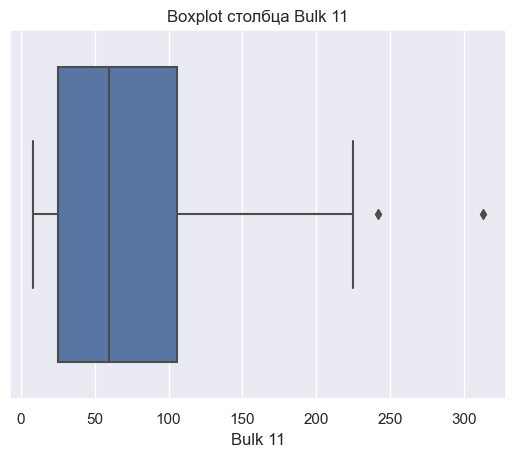

min:  -95.75
max:  226.25
Количество выбросов:  2


In [74]:
build_graphics('Bulk 11', data)

Больше 300 не сильно крайний выброс, думаю можно оставить

### Bulk 12

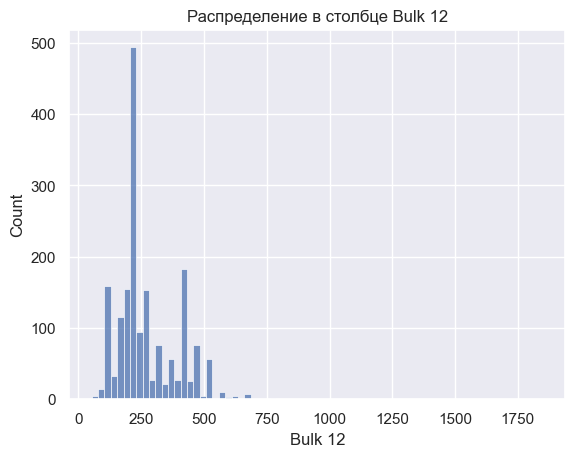

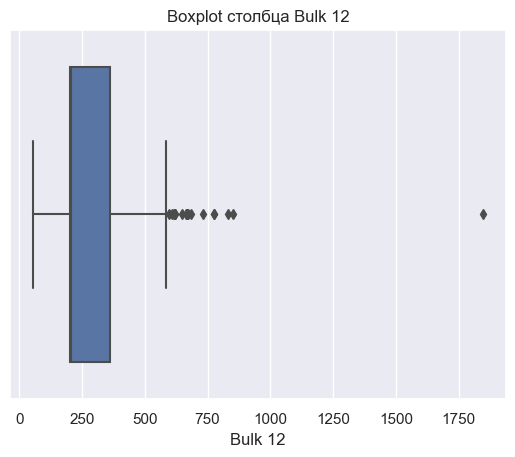

min:  -30.0
max:  594.0
Количество выбросов:  20


In [75]:
build_graphics('Bulk 12', data)

убрать то, что больше 1750

### Bulk 13

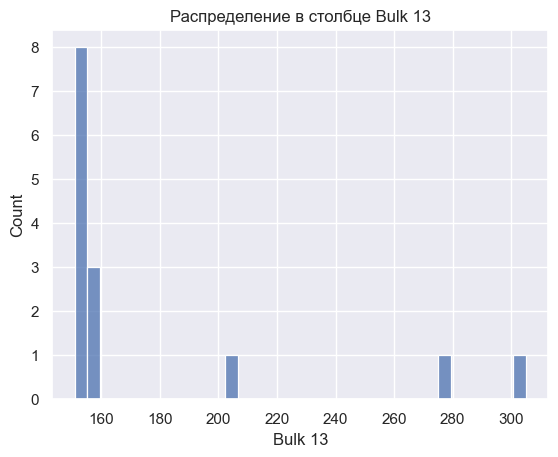

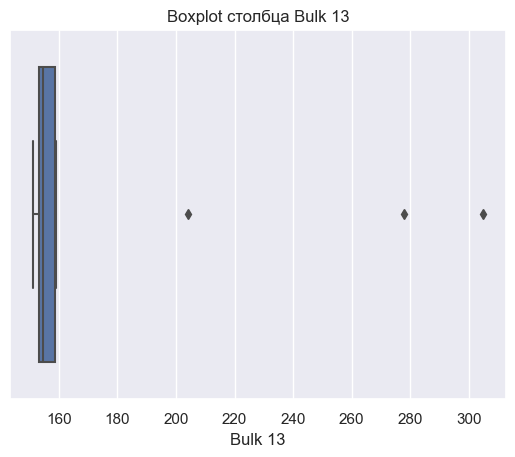

min:  145.375
max:  166.375
Количество выбросов:  3


In [76]:
build_graphics('Bulk 13', data)

Здесь оставим

### Bulk 14

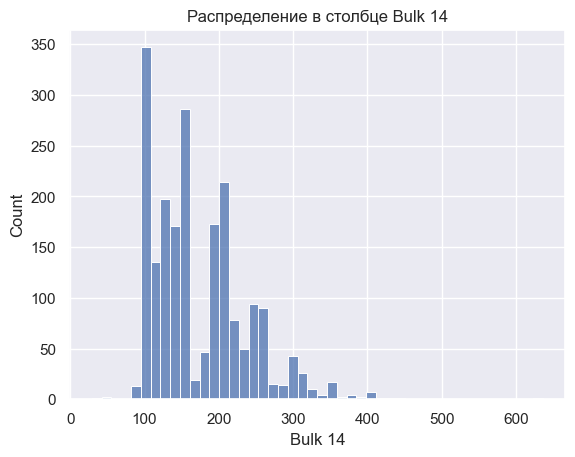

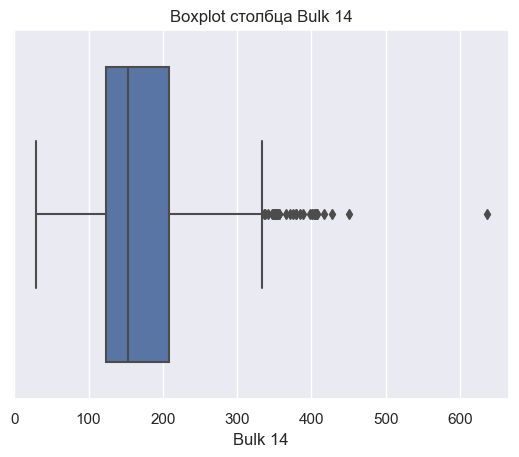

min:  -4.5
max:  335.5
Количество выбросов:  39


In [77]:
build_graphics('Bulk 14', data)

Уберём то, что больше 600

### Bulk 15

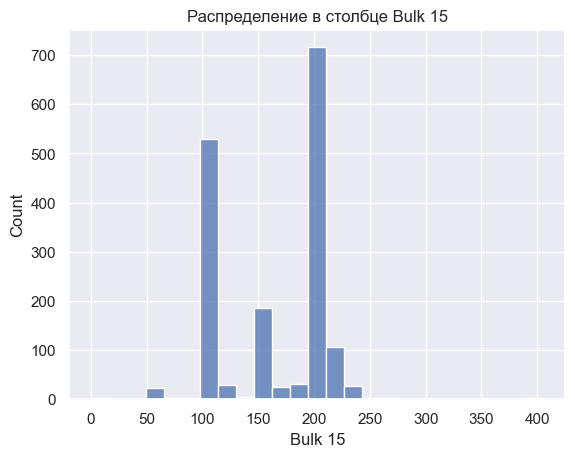

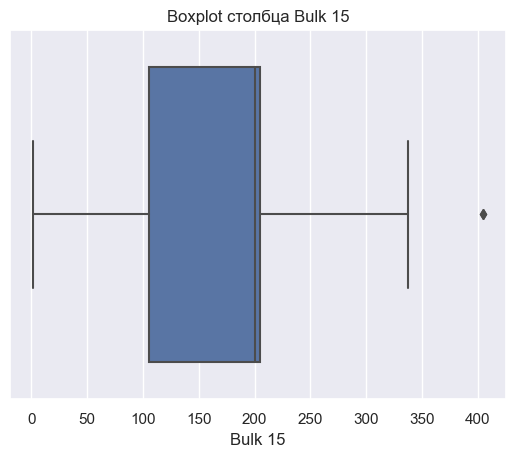

min:  -45.0
max:  355.0
Количество выбросов:  2


In [78]:
build_graphics('Bulk 15', data)

Уберём то, что больше 400

### Газ 1

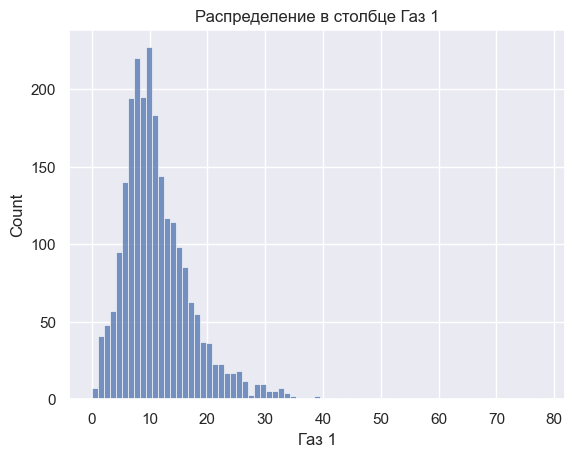

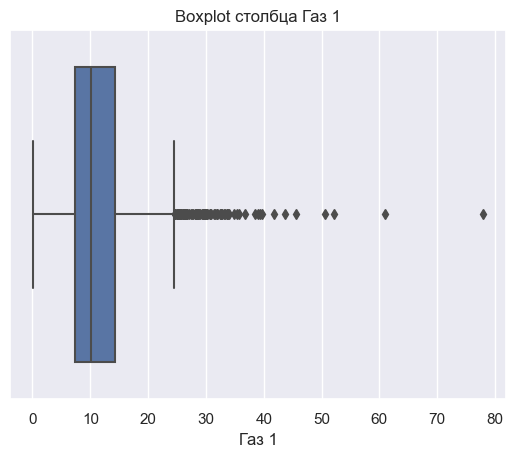

min:  -3.1191666927000004
max:  24.6198054905
Количество выбросов:  93


In [79]:
build_graphics('Газ 1', data)

Уберём то, что больше 50

### first_temperature

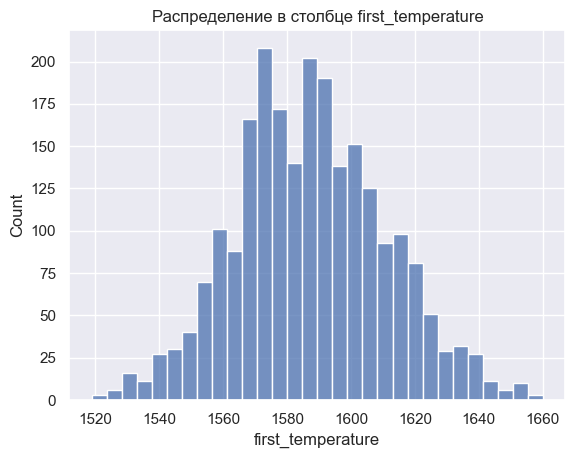

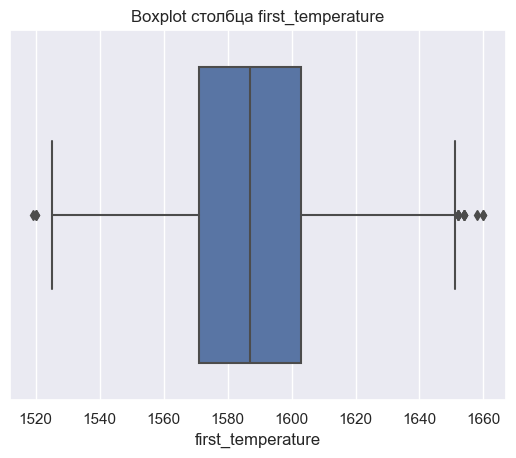

min:  1523.0
max:  1651.0
Количество выбросов:  14


In [80]:
build_graphics('first_temperature', data)

Выбросы не такие уж и крайние, оставим

### last_temperature

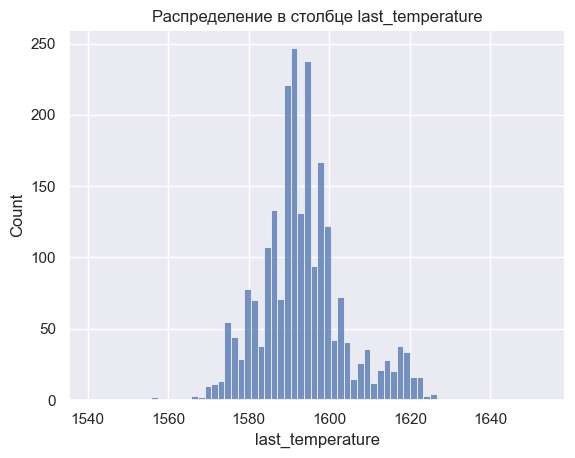

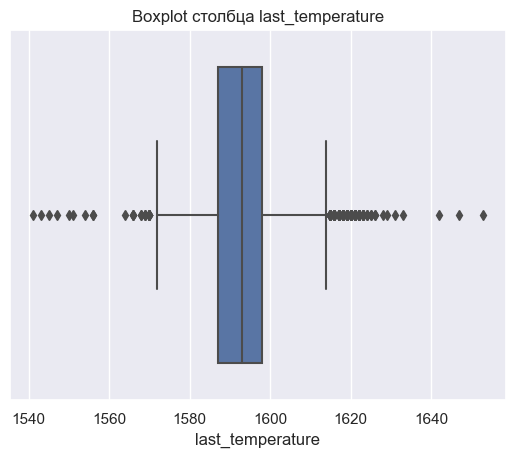

min:  1570.5
max:  1614.5
Количество выбросов:  181


In [81]:
build_graphics('last_temperature', data)

Думаю, целевой признак можно не трогать

### Wire 1

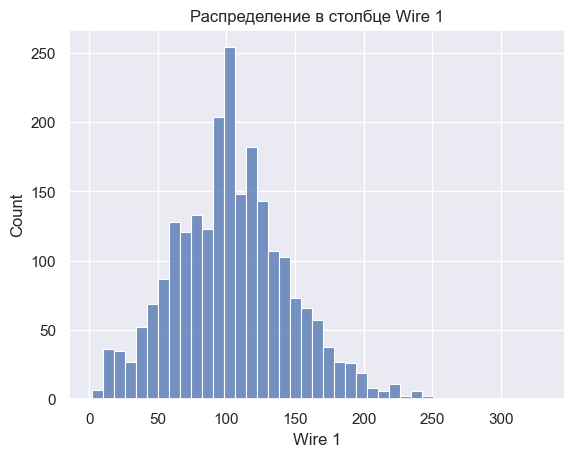

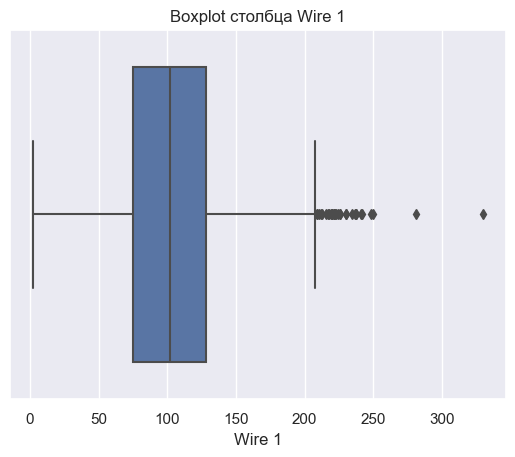

min:  -4.661692000000002
max:  207.882116
Количество выбросов:  31


In [82]:
build_graphics('Wire 1', data)

Уберём то, что больше 260

### Wire 2

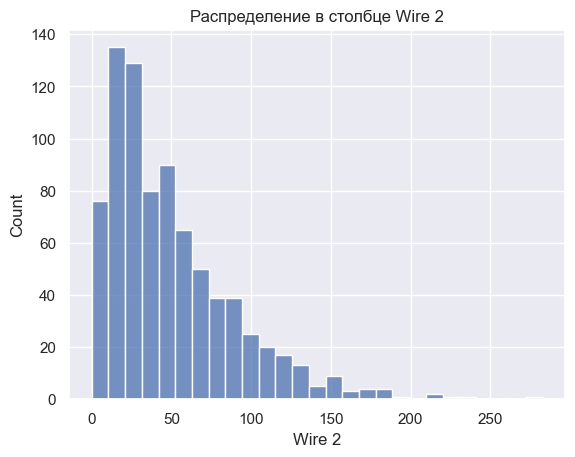

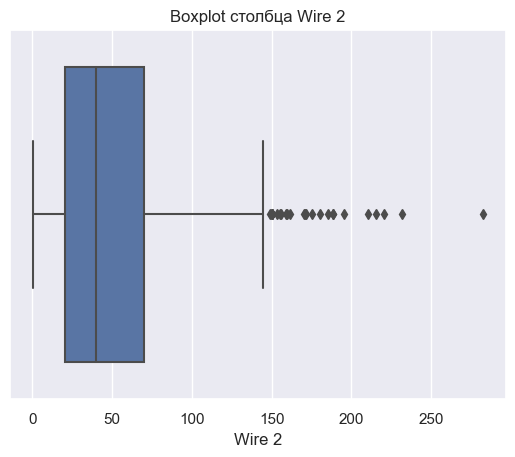

min:  -54.6421235
max:  144.88396849999998
Количество выбросов:  26


In [83]:
build_graphics('Wire 2', data)

Уберём то, что больше 250

### Wire 3

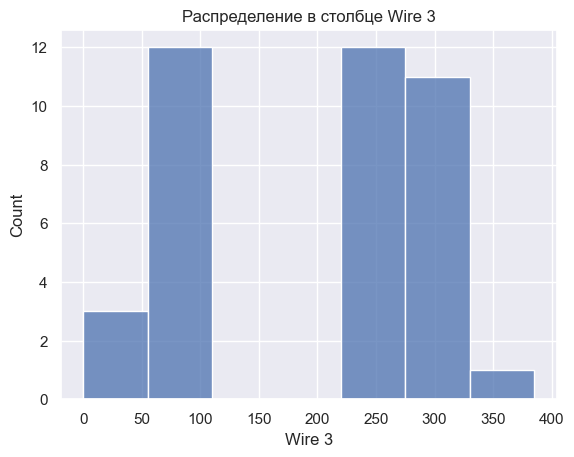

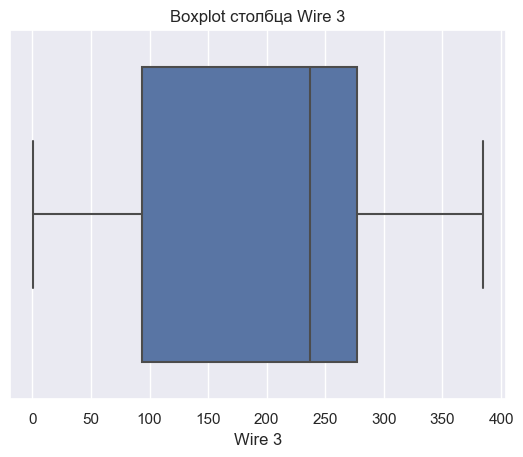

min:  -182.63044724999992
max:  552.8883507499999
Количество выбросов:  0


In [84]:
build_graphics('Wire 3', data)

### Wire 4

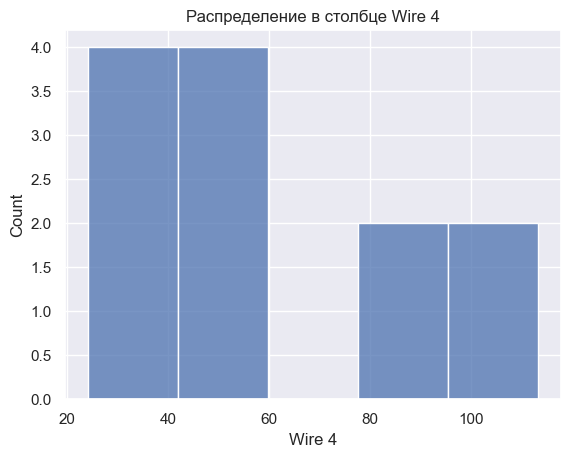

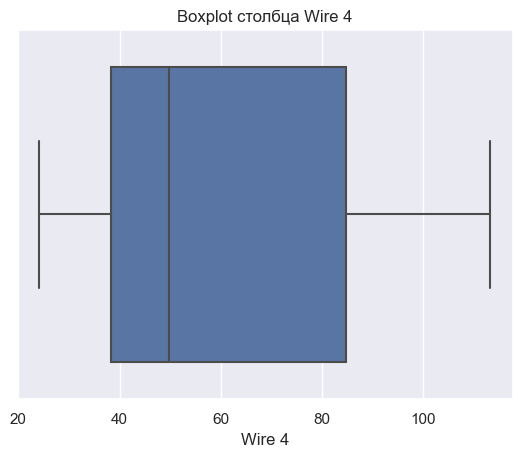

min:  -31.264862499999992
max:  154.3678435
Количество выбросов:  0


In [85]:
build_graphics('Wire 4', data)

### Wire 5

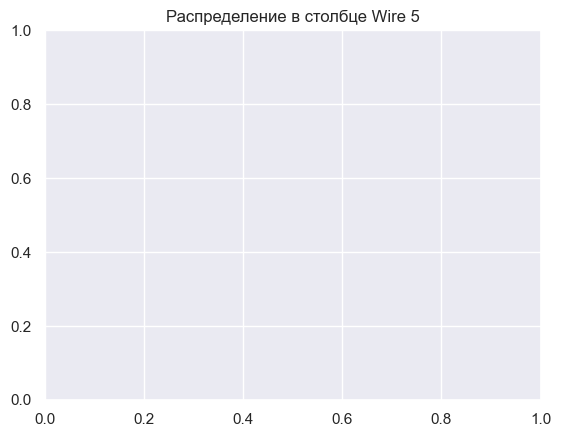

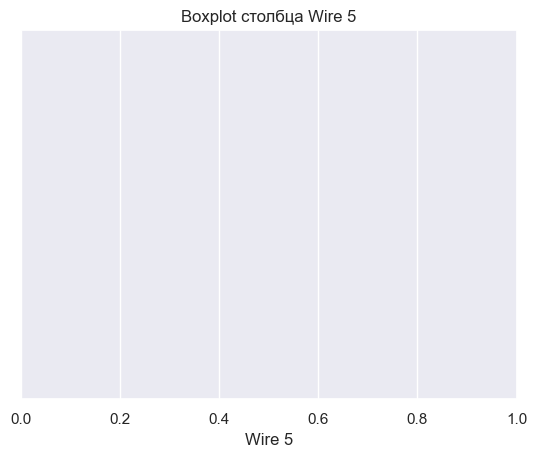

min:  nan
max:  nan
Количество выбросов:  0


In [86]:
build_graphics('Wire 5', data)

Пустой столбец, хотелось бы убрать, но на prod могут использовать его

### Wire 6

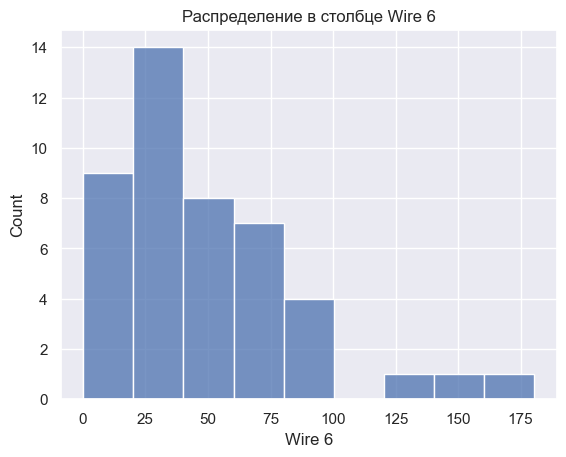

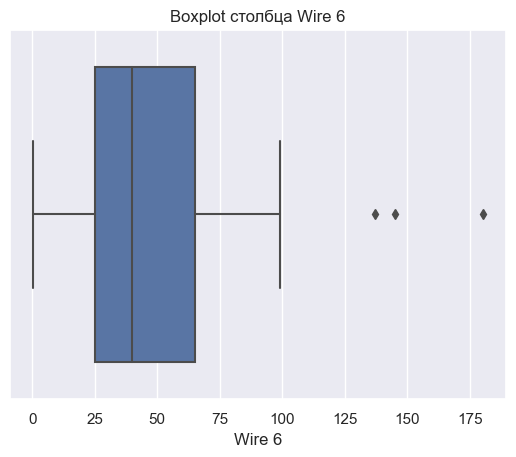

min:  -34.92059999999999
max:  125.0106
Количество выбросов:  3


In [87]:
build_graphics('Wire 6', data)

Данных мало, думаю оставить

### Wire 7

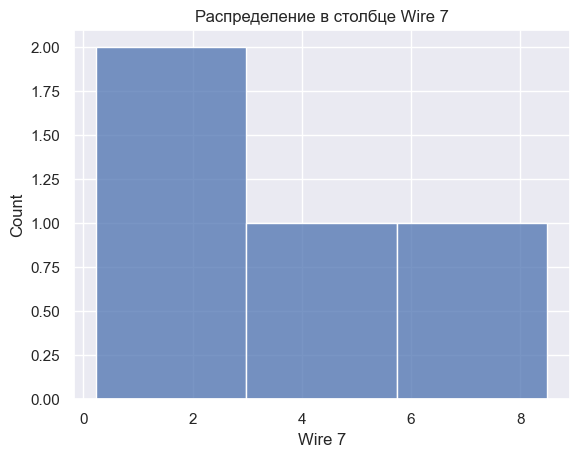

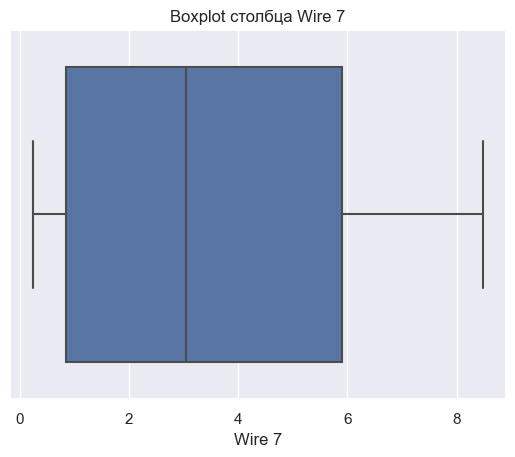

min:  -6.726161000000002
max:  13.474279000000003
Количество выбросов:  0


In [88]:
build_graphics('Wire 7', data)

### Wire 8

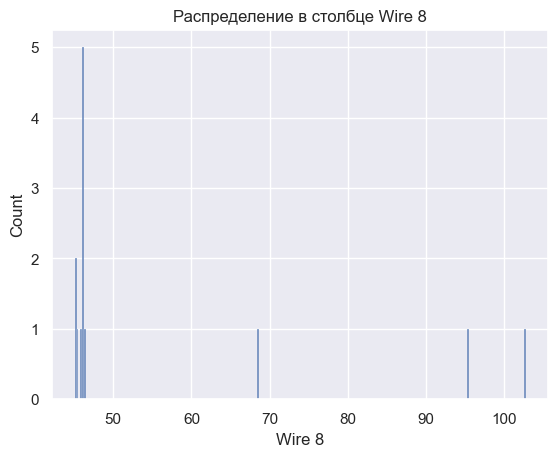

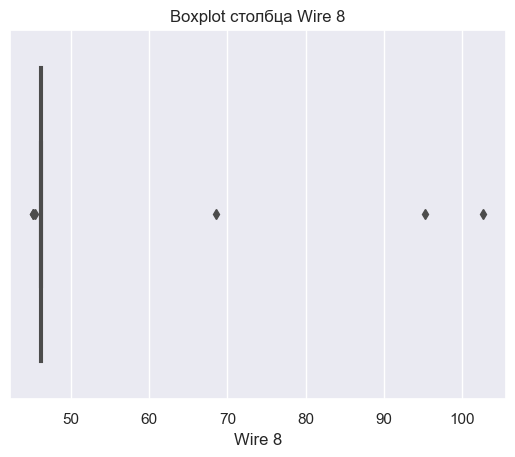

min:  45.58579900000001
max:  46.696518999999995
Количество выбросов:  6


In [89]:
build_graphics('Wire 8', data)

Данных мало, оставим

### Wire 9

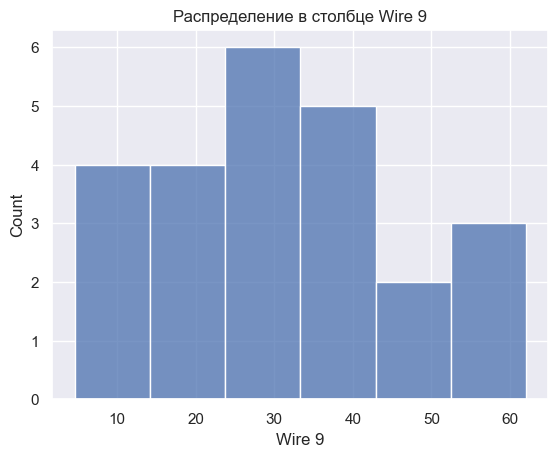

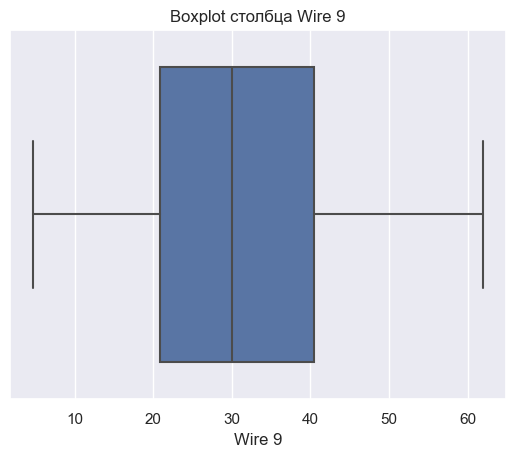

min:  -8.735999250000003
max:  70.03360075
Количество выбросов:  0


In [90]:
build_graphics('Wire 9', data)

### time

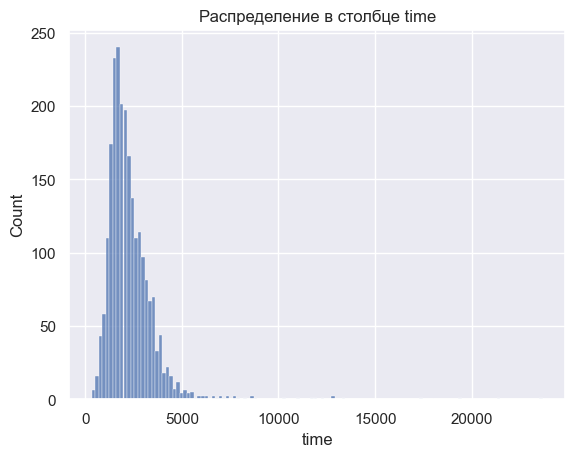

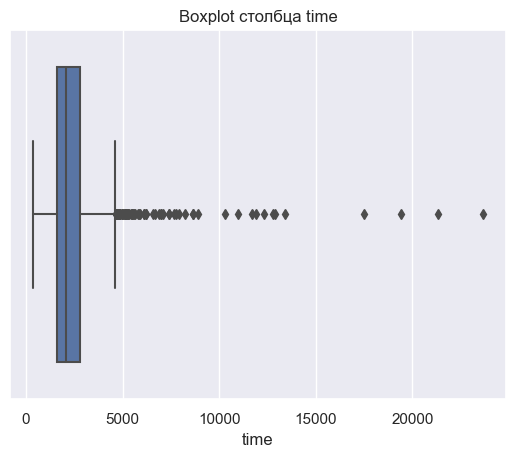

min:  -237.0
max:  4611.0
Количество выбросов:  68


In [91]:
build_graphics('time', data)

Уберем то, что больше 15000

<a id='summary_emissions'></a>
### Итого по выбросам

- work > 3000
- Реактивная мощность > 0.9
- Bulk 1 > 175
- Bulk 5 > 600
- Bulk 6 > 500
- Bulk 12 > 1750
- Bulk 14 > 600
- Bulk 15 > 400
- Газ 1 > 50
- Wire 1 > 260
- Wire 2 > 250
- time > 15000

### Корреляция

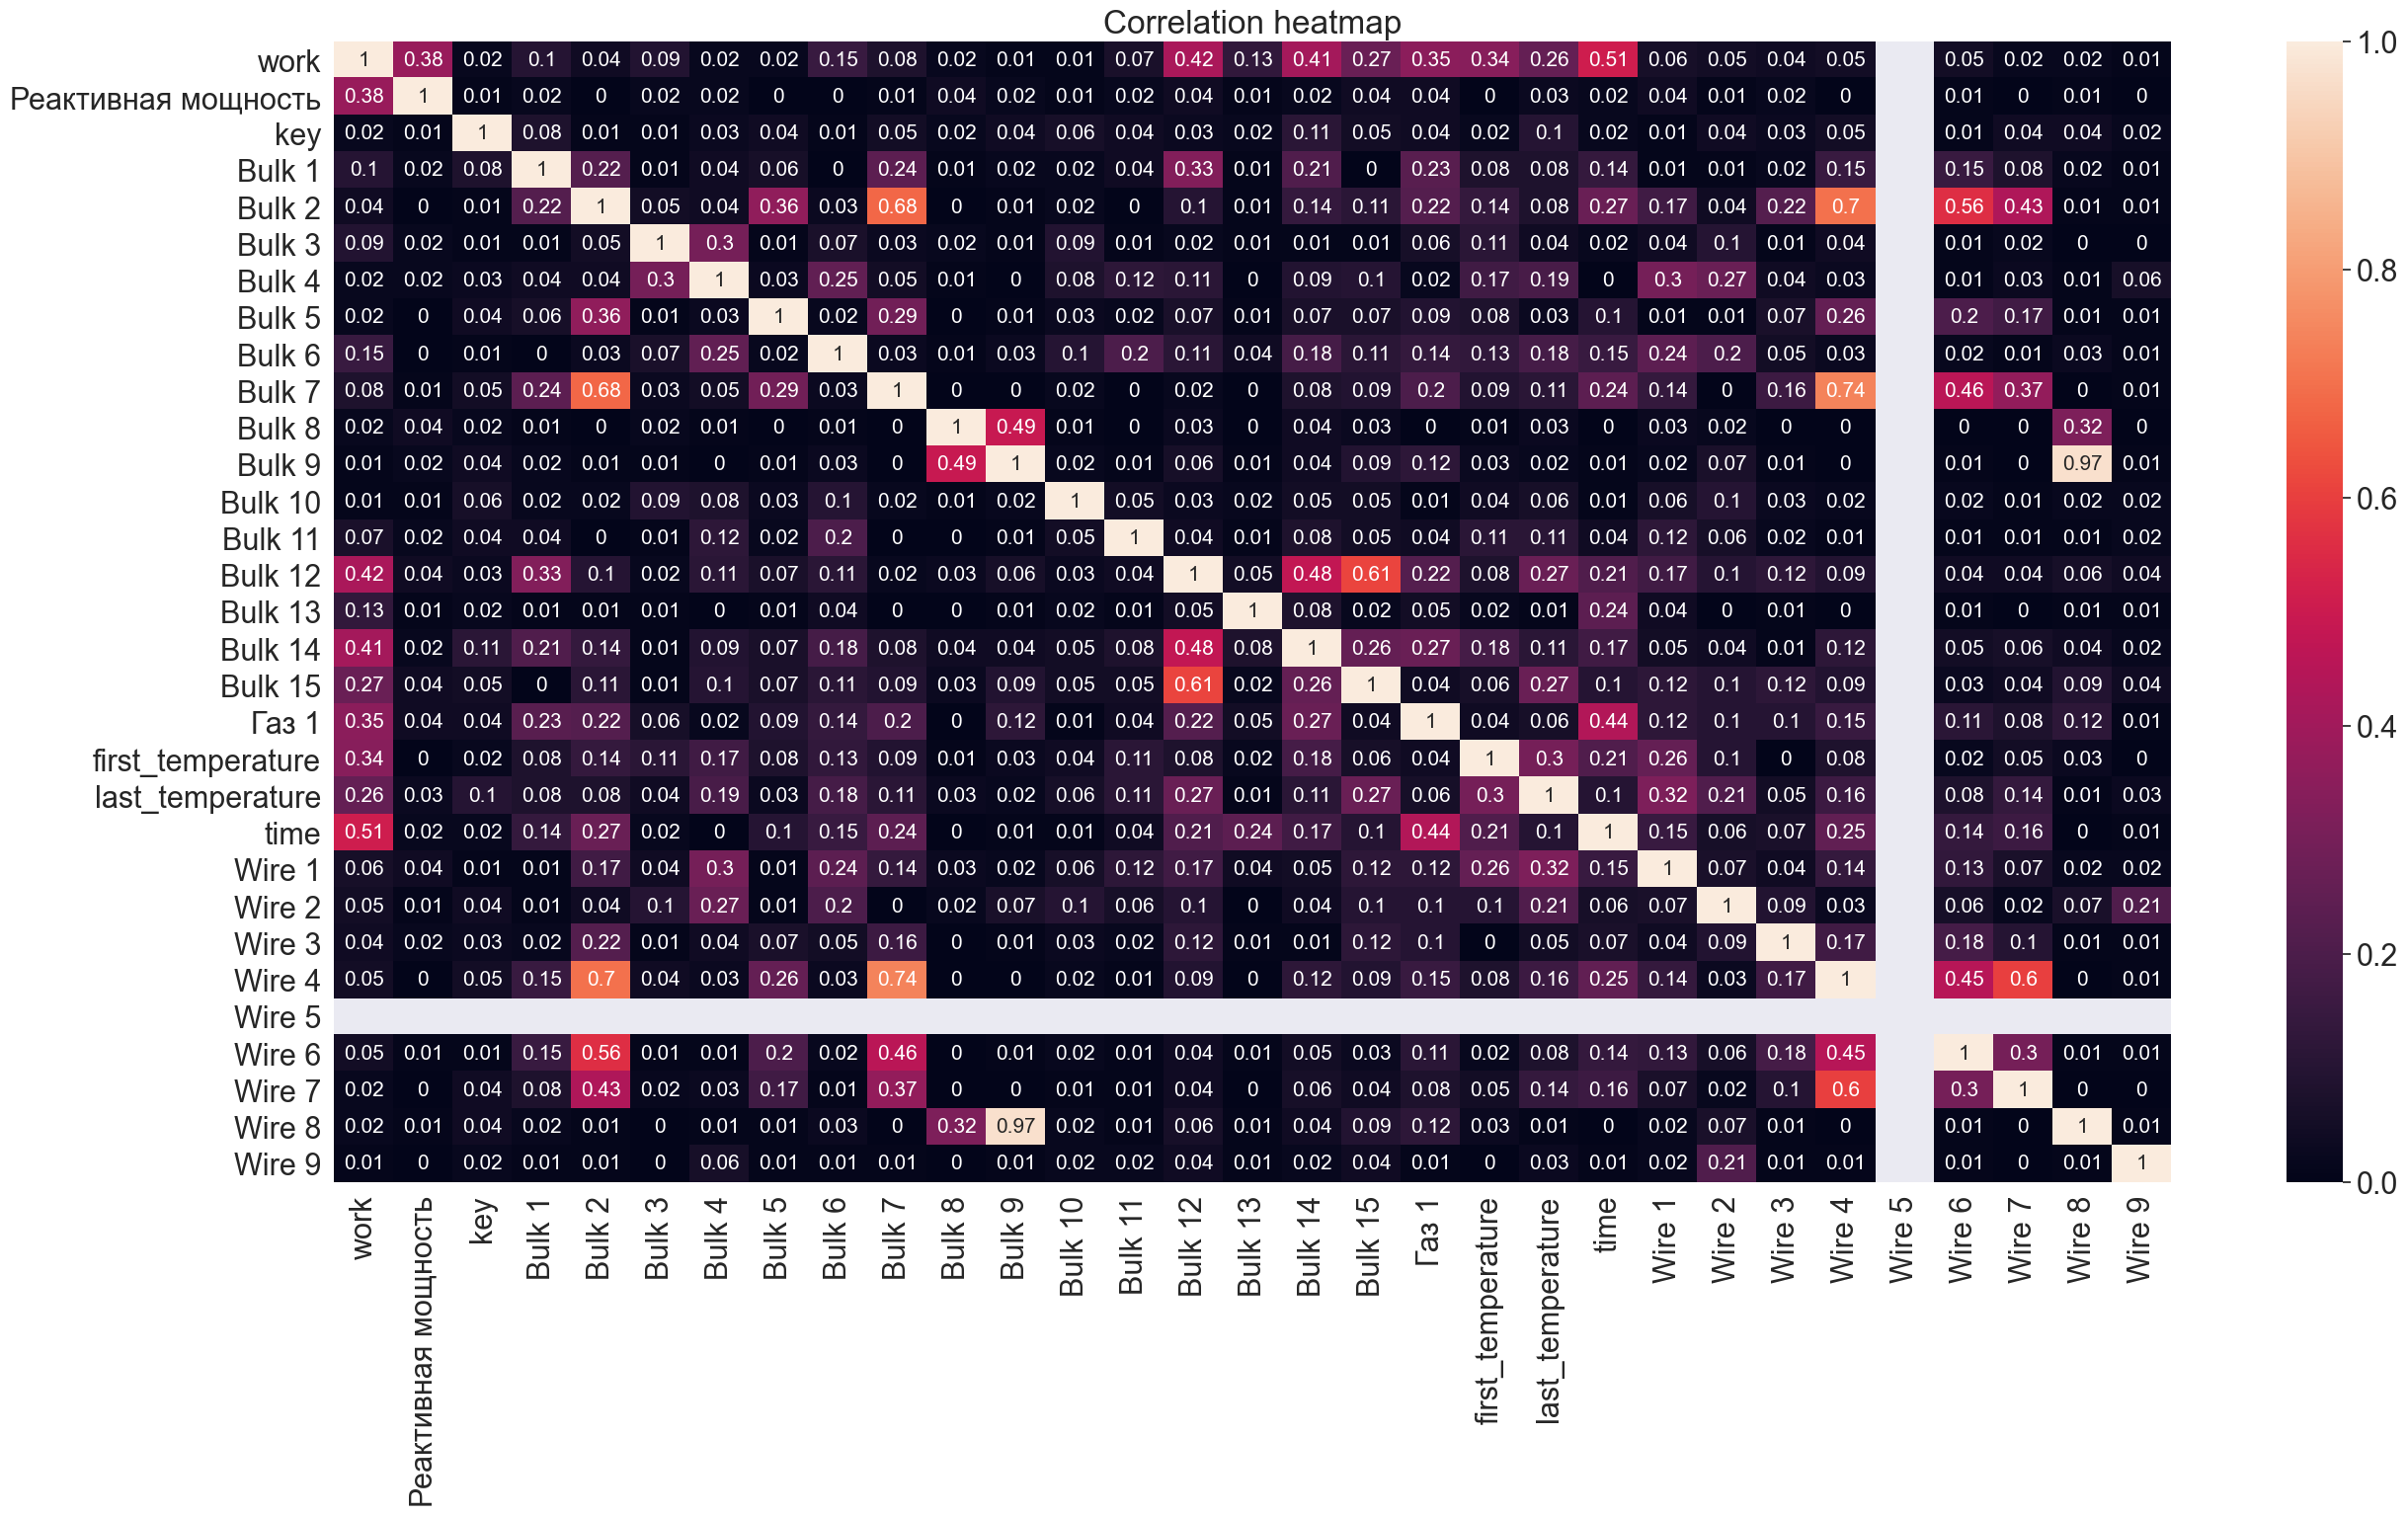

In [95]:
plt.figure(figsize=(30,15))
plt.title('Correlation heatmap')
sns.set(font_scale=2)
sns.heatmap(data.corr().abs().round(2), annot=True, annot_kws={"fontsize":15});

Bulk 9 и Wire 8 имеют высокую кореляцию, но там данных мало

## Обучение

In [96]:
RANDOM_STATE = 50623

In [97]:
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

In [98]:
train.shape

(1743, 31)

In [99]:
test.shape

(582, 31)

Удалим выбросы

In [100]:
train = train[~((train['work'] > 3000) | (train['Реактивная мощность'] > 0.9) | \
                (train['Bulk 1'] > 175) | (train['Bulk 5'] > 600) | (train['Bulk 6'] > 500) | \
                (train['Bulk 12'] > 1750) | (train['Bulk 14'] > 600) | (train['Bulk 15'] > 400) | \
                (train['Газ 1'] > 50) | (train['Wire 1'] > 260) | (train['Wire 2'] > 250) | \
                (train['time'] > 15000))]

In [101]:
train.shape

(1731, 31)

In [102]:
feature_train = train.drop(['last_temperature', 'key'], axis=1)
feature_test = test.drop(['last_temperature', 'key'], axis=1)
target_train = train['last_temperature']
target_test = test['last_temperature']

In [103]:
feature_train.shape

(1731, 29)

In [104]:
feature_test.shape

(582, 29)

### Linear Regression

не забываем убрать коррелирующие данные

In [105]:
feature_train_linear = feature_train.drop(['Wire 8'], axis=1)

In [106]:
feature_train_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1731 entries, 1293 to 163
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   work                 1731 non-null   float64
 1   Реактивная мощность  1731 non-null   float64
 2   Bulk 1               1731 non-null   float64
 3   Bulk 2               1731 non-null   float64
 4   Bulk 3               1731 non-null   float64
 5   Bulk 4               1731 non-null   float64
 6   Bulk 5               1731 non-null   float64
 7   Bulk 6               1731 non-null   float64
 8   Bulk 7               1731 non-null   float64
 9   Bulk 8               1731 non-null   float64
 10  Bulk 9               1731 non-null   float64
 11  Bulk 10              1731 non-null   float64
 12  Bulk 11              1731 non-null   float64
 13  Bulk 12              1731 non-null   float64
 14  Bulk 13              1731 non-null   float64
 15  Bulk 14              1731 non-null  

In [107]:
num_features = feature_train_linear.columns.to_list()
col_transformer = make_column_transformer(
    (
        StandardScaler(), 
        num_features
    )
)

In [108]:
%%time

model_linear = LinearRegression()

pipeline_linear = make_pipeline(col_transformer, model_linear)

param_grid_linear = {}

gs_linear = GridSearchCV(
    pipeline_linear, 
    param_grid=param_grid_linear, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

gs_linear.fit(feature_train_linear, target_train)

gs_linear_best_score = gs_linear.best_score_ * -1

# лучшее значение MAE на кросс-валидации
print(f'best_score: {gs_linear_best_score}')

best_score: 6.385503410291221
CPU times: total: 31.2 ms
Wall time: 2.4 s


### Random Forest

In [109]:
%%time

model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

pipeline_forest = make_pipeline(model_forest)

param_grid_forest = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 10),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}

gs_forest = GridSearchCV(
    pipeline_forest, 
    param_grid=param_grid_forest, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

gs_forest.fit(feature_train, target_train)

gs_forest_best_score = gs_forest.best_score_ * -1
gs_forest_best_params = gs_forest.best_params_

# лучшее значение MAE на кросс-валидации
print(f'best_score: {gs_forest_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_forest_best_params}')

best_score: 6.451413392314032
best_params: {'randomforestregressor__max_depth': 9, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__n_estimators': 250}
CPU times: total: 3.69 s
Wall time: 1min 2s


### CatBoost

In [110]:
%%time
model_Cat = CatBoostRegressor(random_state=RANDOM_STATE, allow_writing_files=False)


# param_grid_Cat = {'learning_rate': [0.01, 0.05, 0.1, 0.3],
#         'depth': range(3, 10),
#         'l2_leaf_reg': [1, 3, 5, 7, 9],
#         # 'iterations': [700],
#         'logging_level':['Silent']}

param_grid_Cat = {'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'depth': [3],
        'l2_leaf_reg': [9],
        'logging_level':['Silent']}


gs_Cat = GridSearchCV(
    estimator= model_Cat,
    param_grid=param_grid_Cat, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

gs_Cat.fit(feature_train, target_train)

gs_Cat_best_score = gs_Cat.best_score_ * -1
gs_Cat_best_params = gs_Cat.best_params_
# лучшее значение MAE на кросс-валидации
print(f'best_score: {gs_Cat_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_Cat_best_params}')

best_score: 6.083018577697054
best_params: {'depth': 3, 'l2_leaf_reg': 9, 'learning_rate': 0.05, 'logging_level': 'Silent'}
CPU times: total: 7.88 s
Wall time: 17min 52s


### LightGBM

In [111]:
num_features = feature_train.columns.to_list()
col_transformer = make_column_transformer(
    (
        StandardScaler(), 
        num_features
    )
)

In [112]:
%%time

model_LGBM = LGBMRegressor(random_state=RANDOM_STATE)

pipeline_LGBM = make_pipeline(col_transformer, model_LGBM)

param_grid_LGBM = {
    'lgbmregressor__n_estimators': range(50, 251, 10),
    'lgbmregressor__max_depth': range(-1, 12),
    'lgbmregressor__learning_rate ': [0.01, 0.05, 0.1, 0.3, 0.5]
}

gs_LGBM = GridSearchCV(
    pipeline_LGBM, 
    param_grid=param_grid_LGBM, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

gs_LGBM.fit(feature_train, target_train)

gs_LGBM_best_score = gs_LGBM.best_score_ * -1
gs_LGBM_best_params = gs_LGBM.best_params_

# лучшее значение MAE на кросс-валидации
print(f'best_score: {gs_LGBM_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_LGBM_best_params}')

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
best_score: 6.18086749964743
best_params: {'lgbmregressor__learning_rate ': 0.01, 'lgbmregressor__max_depth': 2, 'lgbmregressor__n_estimators': 240}
CPU times: total: 13.8 s
Wall time: 1min 31s


## Тестирование лучшей модели

Catboost

In [113]:
model_Cat = gs_Cat.best_estimator_
model_Cat.fit(feature_train, target_train)
predictions = model_Cat.predict(feature_test)
print('MAE на тестовой выборке', mean_absolute_error(target_test, predictions))

MAE на тестовой выборке 6.192666252313388


### Важность признаков

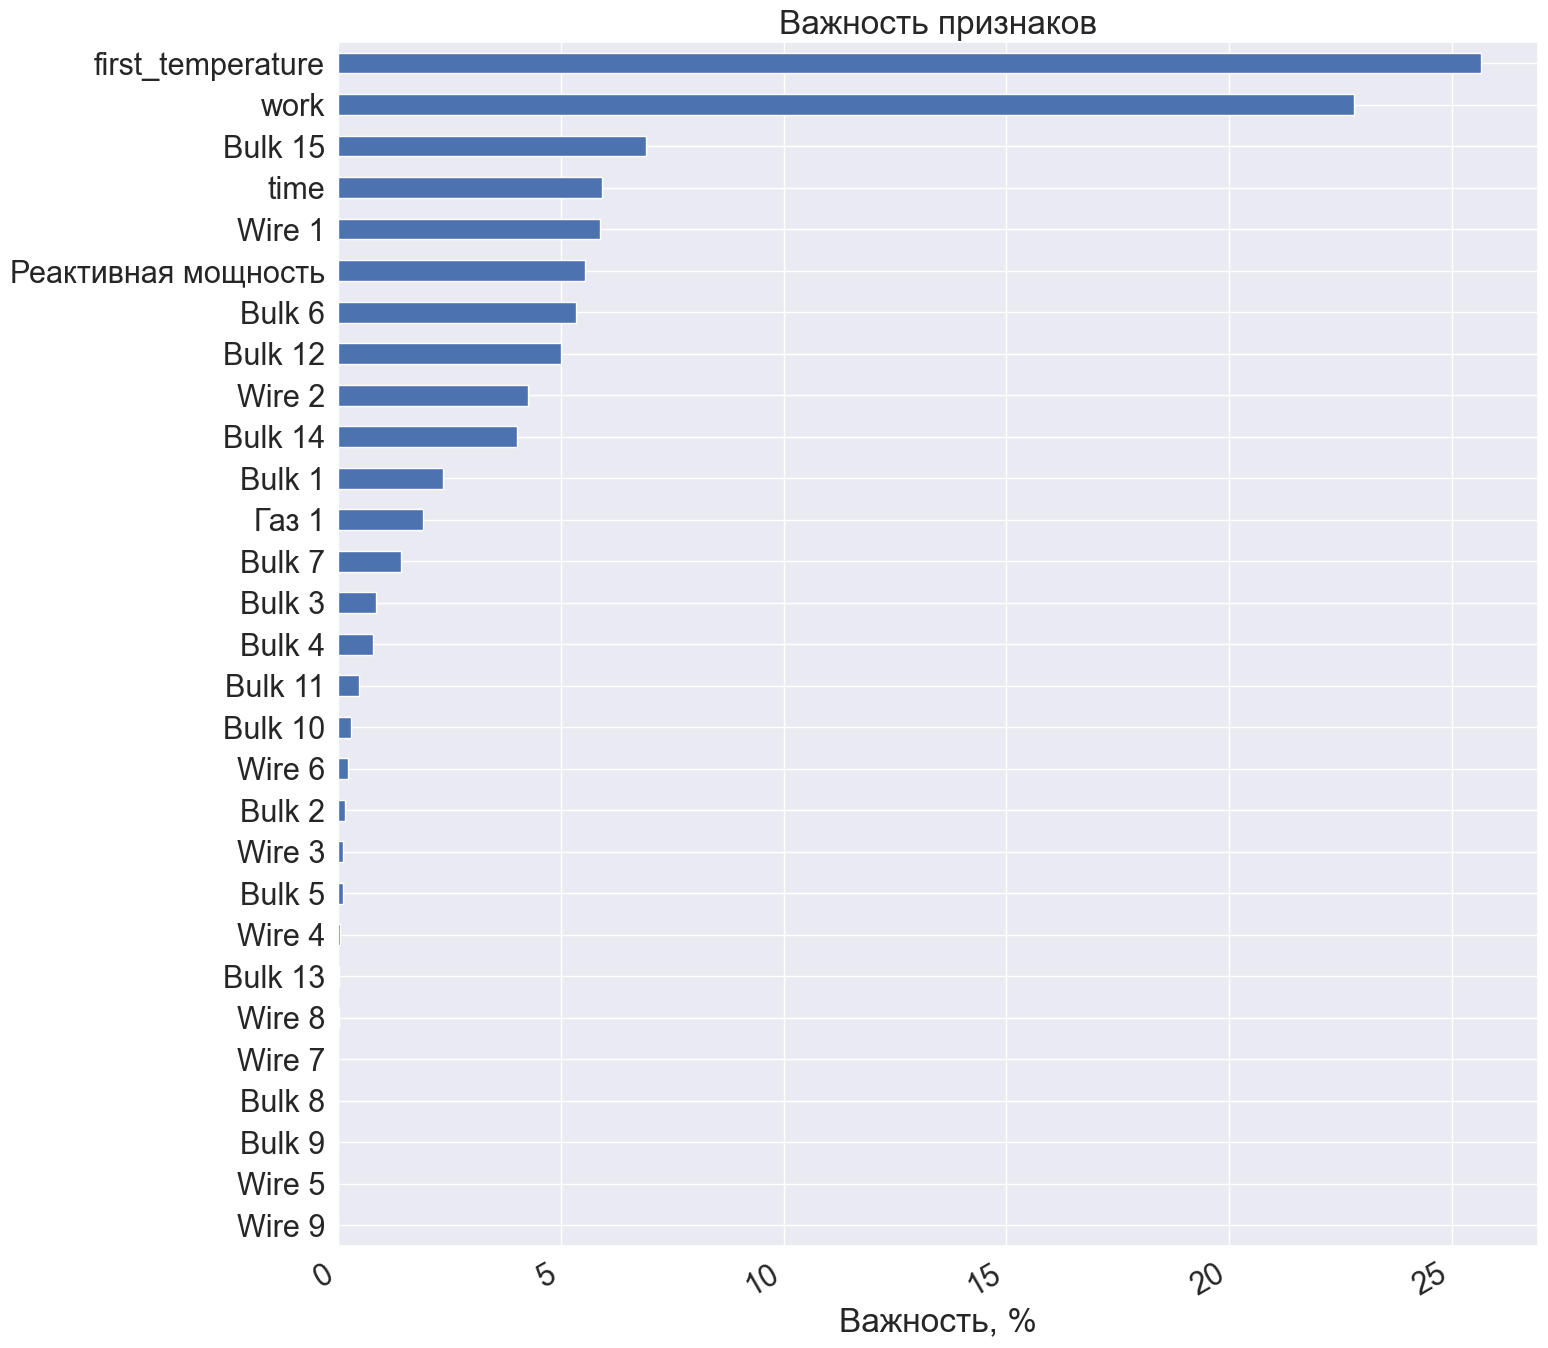

In [116]:
cat_imp = pd.Series(model_Cat.get_feature_importance(),
                         feature_train.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.sort_values().plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_xlabel('Важность, %')
fig.autofmt_xdate()
fig.tight_layout()

### Проверка на константной модели

In [117]:
predictions = pd.Series([target_train.median() for x in range(target_test.shape[0])],index=target_test.index)
print('MAE на константной модели', mean_absolute_error(target_test, predictions))

MAE на константной модели 8.073883161512027


## Вывод

### Исследовательский анализ данных:
После получения одной большой таблицы **были проанализрованы все столбцы на выбросы**.  
Можно найти пункт **"Итого по выбросам"**, где будут указаны все выбросы, которые потом исключались в обучающем датасете.  
Был построен heatmap по корреляции признаков: **нашлись 2 признака, которые имели большую корреляцию(> 0,9).**  


### Обучение моделей
Всего признаков 29  
Было обучено 4 моделей:
- Linear Regression
- Random Forest
- CatBoost
- LightGBM  

Лучшим себя показал CatBoost. Его **MAE на этапе обучения 6.08**  
На **тестовой выборке** удалось достичь **MAE 6.19**  
Наиболее важные признаки: **Первая температура замера** и **Работа**(произведение активной мощности на время)  
MAE на константной модели **8.07**

# Отчёт

- ## Сравнение решения и [плана](#Plan)

**Все пункты плана были выполнены**.  
Но, было добавлено следующее:
  - **удаление аномалий, генерация новых признаков, агрегирование по ключу в предобработке данных** 
  - **исследование призанков после объедения всех таблиц(после второго пункта плана)**:  
  Здесь мы **выявили выбросы**, которые в последствие удалялись в тренировочной выборке. В 4 пункте прописано, что мы удаляем выбросы  
  **Границы выбросов** написаны в следующем [пункте](#summary_emissions)  
  Также стоит отметить, что был построен **heatmap по корреляции**, что в будущем помогло нам в обучении моделей, которым "не нравятся" коррелирующие признаки, например модель Линейной Регрессии
  - в 5 этапе плана добавилась **модель LightGBM**
  - Помимо тестирования лучшей модели на тестовой выборке, был построен **график важности признаков** и было проведено **сравнение лучшей модели с константной**
 
Все выше перечисленное, кроме пункта с добавлением модели LightGBM, было упущено по той причине, что я не сильно углублялся в ход решения и поэтому упустил эти моменты и не написал их, хотя понимал, что некоторые моменты предстоит сделать, например поиск выбросов, так как в 4-ом пунтке у меня написано, что выбросы мы удаляем. Также некоторые моменты подсказал прекрасный тимлид после ревью.  
LightGBM я решил добавить, так как модельки довольно шустро обучались и подумал, почему бы не добавить еще одну модель.

- ## Описание трудностей проекта (и как они были решены)  

В основном, трудность заключалась в том, что работали с 7 таблицами, некоторые из которых имели несколько записей однаковых ключей.  
Всё это решлалось агрегированием по ключу и сведение всех таблиц к одной общей.

- ## Описание ключевых шагов решения
    
  - Загрузка данных
  - "быстрый" анализ данных (методы head, info)
  - Предобработка данных  
    
    На каждой таблице могло делаться следующее:
    
    - Заполнение пустых значений
    - Обработка аномалий (удаление или восстановление)
    - Создание признаков
    - Агрегирование по ключу  
    
    В конечном итоге, всё соединялось в одну таблицу    
    <br>
  - Исследовательский анализ данных:
    - Исследование признаков (гистограммы, выбросы и т.п.)
    - Heatmap корреляции  
  - Обучение моделей
    - Инициализация тестовой и обучающей выборки
    - Инициализация признаков и таргета
    - Применение кросс валидации на моделях Linear Regression, Random Forest, CatBoost, LightGBM с подбором гиперпараметров(использование GridSearchCV) на обучающей выборке
  - Тестирование лучшей модели
    - Проверка на тестовой выборке
    - Анализ важности признаков
    - Сравнение с константной моделью
  
- ## Признаки, которые использовали для обучения и их предобработка

  ### work
  Признак, который обозначает произведение Актиавной мощности на время. Предобработка: конвертирование столбцов в datetime и вычисление этого признака, при агрегировании по ключу использовалась сумма.
  ### Реактивная мощность
  Это среднее реактивной мощности по каждой партии. Предобработка: Восстановление одной записи, где мощность была меньше нуля, и агрегирование по ключу с использованием среднего.
  ### Bulk's
  все столбцы Bulk. Предобработка: заполнение нулями пустых значений
  ### Газ 1
  Всё в порядке. Признак из датасета data_gas_new.csv
  ### first_temperature
  Первый замер температуры. Предобработка: Удаляем партии с супер выбросом(температура меньше 1500),NaN значениями и одним замером температуры, при агрегировании по ключу используем метод first
  ### time
  Время между первым и последним замером температуры. Предобработка: конвертируем столбцы в datetime, находим первую и последнюю запись у партии, вычисляем их разницу в секундах
  ### Wire's
  Все столбцы Wire. Предобработка: заполнение нулями пустых значений


- ## Полное описание модели (с гиперпараметрами, включая random_state, если использовался)

CatBoost Regressor - модель, которая использует градиентный бустинг на решающих деревья.  
Его гиперпараметры:
  - depth: 3 
  - l2_leaf_reg: 9 
  - learning_rate: 0.05 
  - random_state: 50623

- ## Итоговая метрика

MAE: 6.19

- ## Рекомендации по улучшению решения  

Попробовать другие модели;  
Сгенерировать новые признаки;  
Попробовать использовать времянные ряды(есть 2 таблицы неиспользованные и в них есть времянные данные).
